# Train your player

This notebook will give a concrete example on how to train an agent for Quarto using Q-learning.
At the end, it will also show how to submit your implementation to the arena.


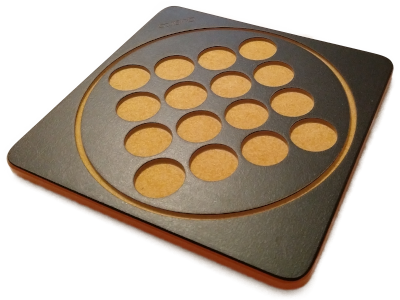
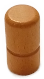
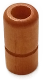
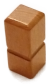
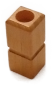
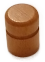
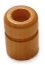
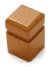
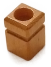
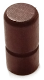
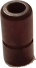
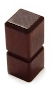
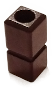
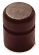
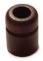
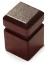
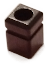

In [2]:
# Create environment
from quarto.environment import Environment
env = Environment()
env

In [3]:
# Implement a Q-learning agent
from quarto.base_player import BasePlayer

class OurPlayer(BasePlayer):
    def __init__(self, train_mode):
        # Whether we are in training or playing mode
        # In training mode, this player will update its Q-table
        # and sometimes take a random action to explore more
        self.train_mode = train_mode
        
        # This agent's Q-table.
        # It is a map from state to action value pre action:
        # q_table[state][action]: float
        self.q_table = defaultdict(lambda: np.zeros(256))
        
        # Epsilon scheduling
        self.epsilon = 1
        self.min_epsilon = 0.01
        self.epsilon_decay = 0.99995
        
        # Q-table update hyperparameters
        self.alpha = 0.1
        self.gamma = 1
        
        # Q-table update helper variables
        self.prev_state = None
        self.prev_action = None

    def start(self, state, valid_actions):
        # First move: take the action
        return self._take_action(state, valid_actions)

    def step(self, state, valid_actions, reward):
        # At every other step: update the q-table and take the next action
        # Since the game hasn't finished yet, we can use current knowledge of the q-table
        # to estimate the future reward.
        self._update_q_table(reward + self.gamma * np.max(self.q_table[tuple(state)][valid_actions]))
        return self._take_action(state, valid_actions)

    def end(self, reward):
        # Last step: update the q-table and schedule the next value for epsilon
        # Here, the expected action-value is simply the final reward
        self._update_q_table(reward)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def _update_q_table(self, new_value):
        if self.mode == BasePlayer.TRAIN:
            # Based on the reward of the previous action take at the previous step,
            # update the q-table to be closer to the desired value.
            # Note that, if `alpha` is zero, the q-table is left unchanged,
            # if `alpha` is one, the q-table will simply take the `new_value`.
            # With a value in between, one can control the tradeoff between learning too much
            # or too little from a single move
            q_row = self.q_table[tuple(self.prev_state)]
            q_row[self.prev_action] += self.alpha * (new_value - q_row[self.prev_action])

    def _take_action(self, state, valid_actions):
        # Store the current state, copying it, otherwise the environment could mutate it afterwards
        self.prev_state = state.copy()
        
        if not self.train_mode and np.random.random() <= self.epsilon:
            # Take a random action
            self.prev_action = np.random.choice(valid_actions)
        else:
            # Take the action that has the highest expected future reward,
            # that is, the highest action value
            self.prev_action = valid_actions[np.argmax(self.q_table[tuple(state)][valid_actions])]
        return self.prev_action

    def get_freezed(self):
        # Return a copy of the player, but not in train_mode
        # This is used by the training loop, to replace the adversary from time to time
        copy = deepcopy(self)
        copy.train_mode = False
        return copy

    def save(self):
        # Save the q-table on the disk for future use
        with open('player.bin', 'wb') as fp:
            pickle.dump(dict(self.q_table), fp, protocol=4)